In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [186]:
# Load the dataset
file_path = 'family_financial_and_transactions_data.xlsx'
data = pd.read_excel(file_path, sheet_name='final_family_financial_and_tran')

In [187]:
# Data Cleaning
# 1. Check for missing values
print("Missing values before cleaning:")
print(data.isnull().sum())

Missing values before cleaning:
Family ID                  0
Member ID                  0
Transaction Date           0
Category                   0
Amount                     0
Income                     0
Savings                    0
Monthly Expenses           0
Loan Payments              0
Credit Card Spending       0
Dependents                 0
Financial Goals Met (%)    0
dtype: int64


In [188]:
# 2. Replace or drop missing values
data['Savings'] = data['Savings'].fillna(data['Savings'].median())  # Replace NaN in Savings with median
data['Income'] = data['Income'].fillna(data['Income'].median())    # Replace NaN in Income with median
data.dropna(subset=['Category'], inplace=True)  # Drop rows with missing Category


In [189]:
# 3. Check if data types are correct
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'])  
data['Income'] = pd.to_numeric(data['Income'], errors='coerce')
data['Savings'] = pd.to_numeric(data['Savings'], errors='coerce')
data['Financial Goals Met (%)'] = pd.to_numeric(data['Financial Goals Met (%)'], errors='coerce')


In [190]:
# 4. Check for duplicates and remove them
data = data.drop_duplicates()


In [191]:
# 5. Cap extreme values
def cap_outliers(series, lower_percentile=1, upper_percentile=99):
    lower_limit = np.percentile(series, lower_percentile)
    upper_limit = np.percentile(series, upper_percentile)
    return np.clip(series, lower_limit, upper_limit)

data['Amount'] = cap_outliers(data['Amount'])
data['Savings'] = cap_outliers(data['Savings'])
data['Income'] = cap_outliers(data['Income'])
data['Monthly Expenses'] = cap_outliers(data['Monthly Expenses'])
data['Loan Payments'] = cap_outliers(data['Loan Payments'])
data['Credit Card Spending'] = cap_outliers(data['Credit Card Spending'])


In [192]:
# 6. Re-check for missing or invalid data after cleaning
print("\nMissing values after cleaning:")
print(data.isnull().sum())



Missing values after cleaning:
Family ID                  0
Member ID                  0
Transaction Date           0
Category                   0
Amount                     0
Income                     0
Savings                    0
Monthly Expenses           0
Loan Payments              0
Credit Card Spending       0
Dependents                 0
Financial Goals Met (%)    0
dtype: int64


In [193]:
# Preprocessing: Adding ratios
data['Savings-to-Income Ratio'] = data['Savings'] / data['Income']
data['Expenses-to-Income Ratio'] = data['Monthly Expenses'] / data['Income']
data['Loan-to-Income Ratio'] = data['Loan Payments'] / data['Income']
data['Credit Card Spending-to-Income'] = data['Credit Card Spending'] / data['Income']


In [194]:
# Aggregating spending by family and members
family_spending = data.groupby('Family ID')['Amount'].sum()
member_spending = data.groupby('Member ID')['Amount'].sum()


In [195]:
# Calculating financial score
def calculate_financial_health(row):
    
    weights = {
        'savings': 0.3,
        'expenses': 0.2,
        'loan': 0.2,
        'credit_card': 0.1,
        'categories': 0.1,
        'goals': 0.1
    }

    # Calculate individual scores
    savings_score = np.clip(row['Savings-to-Income Ratio'] * 100, 0, 100)
    expenses_score = np.clip((1 - row['Expenses-to-Income Ratio']) * 100, 0, 100)
    loan_score = np.clip((1 - row['Loan-to-Income Ratio']) * 100, 0, 100)
    credit_card_score = np.clip((1 - row['Credit Card Spending-to-Income']) * 100, 0, 100)
    category_score = 100 - row['Amount'] if row['Category'] in ['Travel', 'Entertainment'] else 100
    goals_score = row['Financial Goals Met (%)']

    # Weighted average
    total_score = (
        weights['savings'] * savings_score +
        weights['expenses'] * expenses_score +
        weights['loan'] * loan_score +
        weights['credit_card'] * credit_card_score +
        weights['categories'] * category_score +
        weights['goals'] * goals_score
    )
    return total_score

In [196]:
data['Financial Health Score'] = data.apply(calculate_financial_health, axis=1)

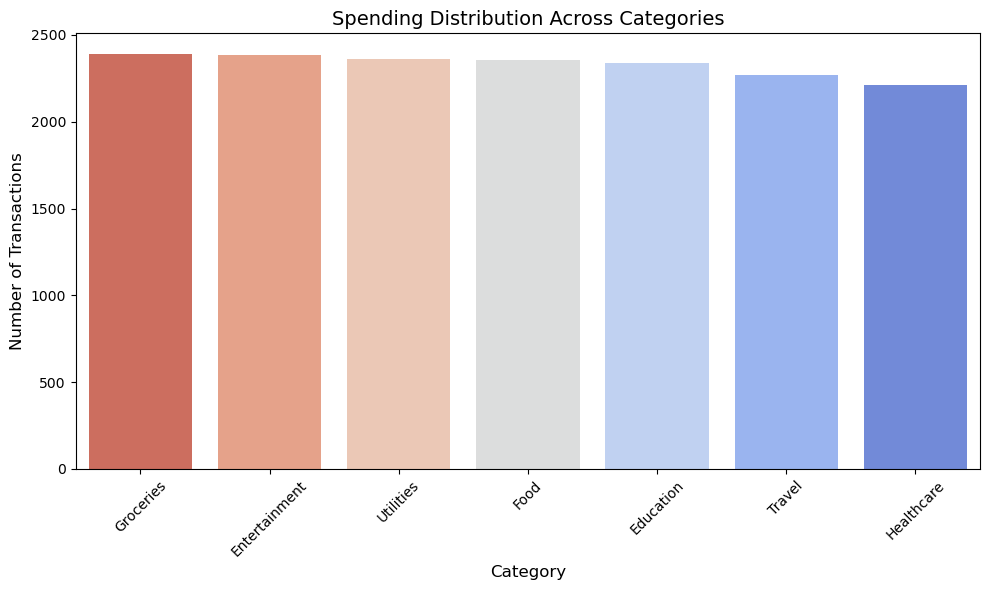

In [197]:
# Visualization 1: Spending Distribution Across Categories
plt.figure(figsize=(10, 6))
sns.barplot(x=data['Category'].value_counts().index, y=data['Category'].value_counts().values, palette="coolwarm_r")
plt.title('Spending Distribution Across Categories', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

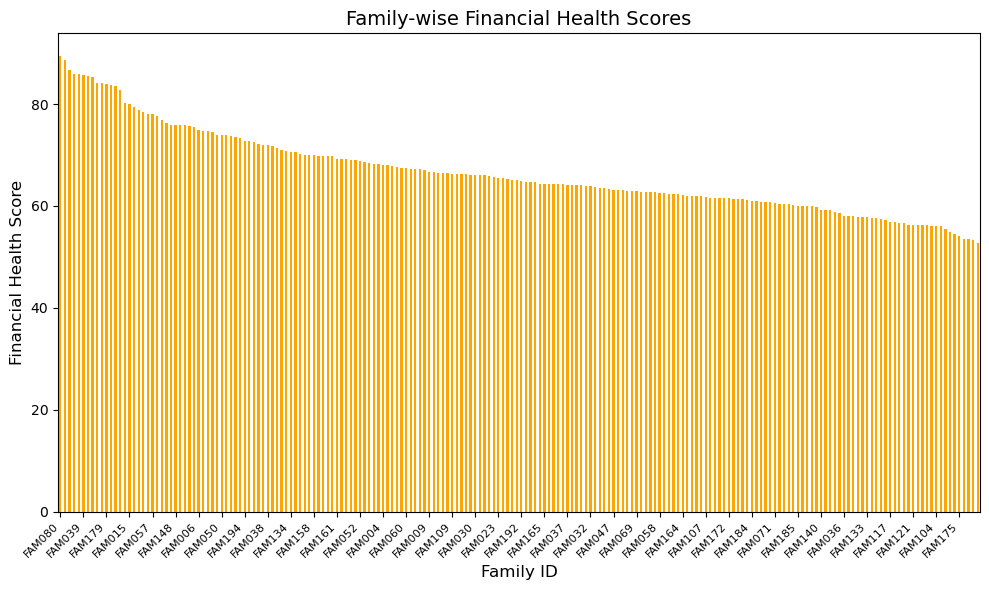

In [198]:
# Visualization 2: Family-wise Financial Health Scores
family_scores = data.groupby('Family ID')['Financial Health Score'].mean()
plt.figure(figsize=(10, 6))
family_scores.sort_values(ascending=False).plot(kind='bar', color='orange')
plt.title('Family-wise Financial Health Scores', fontsize=14)
plt.xlabel('Family ID', fontsize=12)
plt.ylabel('Financial Health Score', fontsize=12)
plt.locator_params(axis='x', nbins=40)
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.tight_layout()
plt.show()

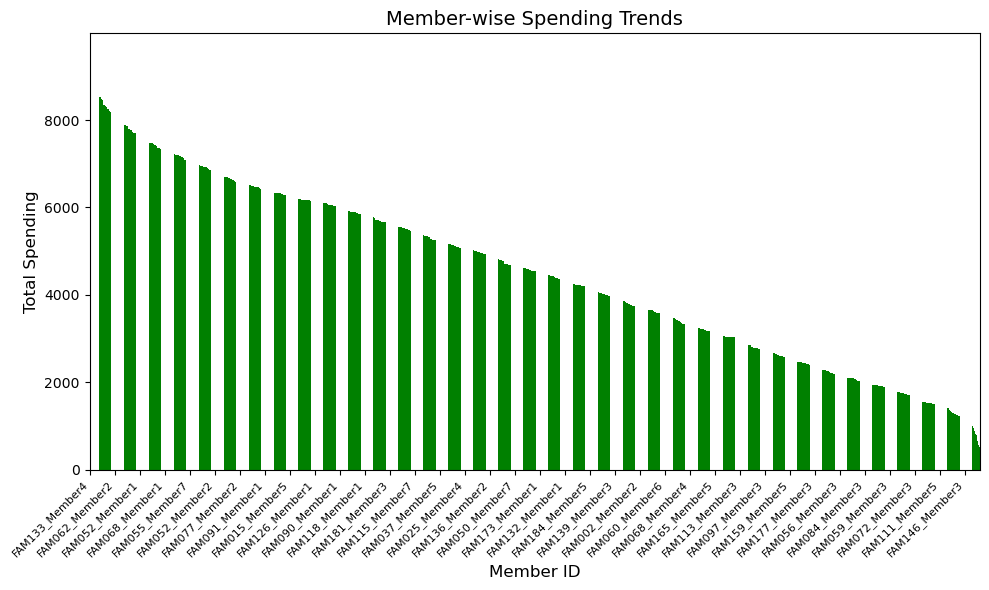

In [199]:
# Visualization 3: Member-wise Spending Trends
member_spending = data.groupby('Member ID')['Amount'].sum()
plt.figure(figsize=(10, 6))
member_spending.sort_values(ascending=False).plot(kind='bar', color='green')
plt.title('Member-wise Spending Trends', fontsize=14)
plt.xlabel('Member ID', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.locator_params(axis='x', nbins=36)
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.tight_layout()
plt.show()

In [200]:
# Correlation Analysis
correlations = data[['Income', 'Monthly Expenses', 'Savings', 'Loan Payments', 
                     'Credit Card Spending', 'Financial Health Score']].corr()


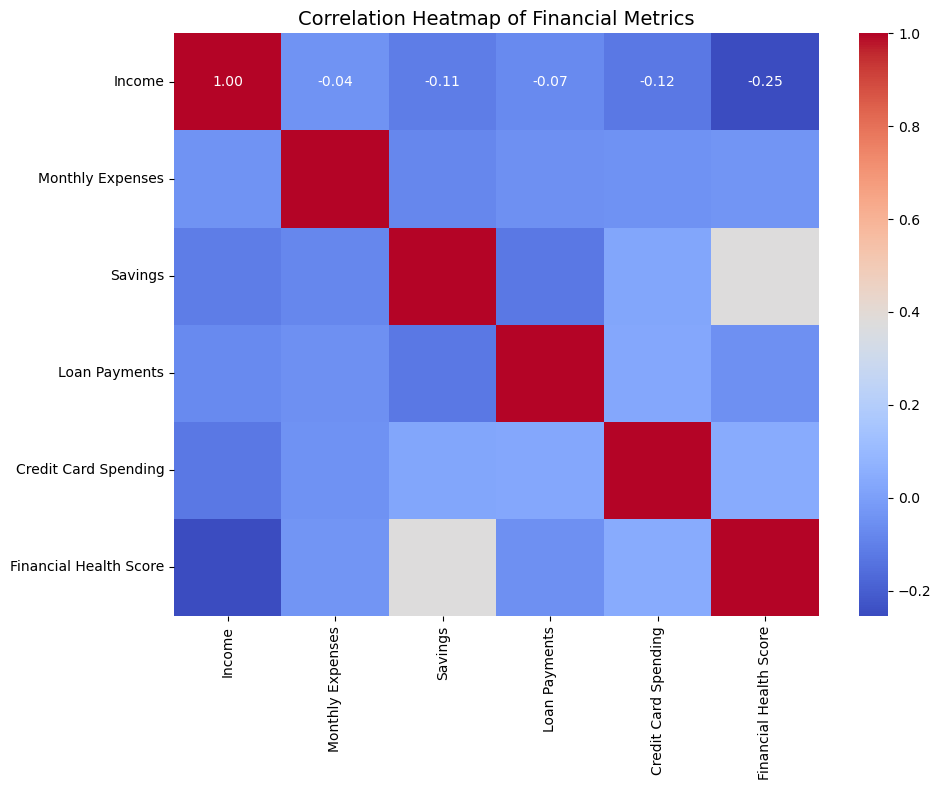

In [201]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Financial Metrics', fontsize=14)
plt.tight_layout()
plt.show()